In [32]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
%matplotlib inline

In [33]:
df_2020 = pd.read_csv('data\_2020\_2020.txt', sep='\t')

# Retirando as linhas que possuem valores nulos
df_2020 = df_2020.drop(df_2020[df_2020['COORD.GEO.X'] == 0].index)
df_2020 = df_2020.drop(df_2020[df_2020['COORD.GEO.Y'] == 0].index)

# Filtrando pelo mês de janeiro
df_2020 = df_2020[df_2020['MES'] == 1]


df_2020.head()

C:\Users\hyago\AppData\Local\Temp\ipykernel_12812\1442728536.py:1: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



NRO_CLIENT     DISTRITO TARIFA  CATEGORIA  CNS_ACT_FP  CNS_ACT_HP SET  \
0         511  LA VICTORIA   BT5B          0       327.9         0.0   G   
1     1413868       CHILCA   BT5B          0       189.0         0.0  CL   
2         524        LINCE   BT5B          0       174.0         0.0  SI   
3     1413624  ATE-VITARTE   BT5B          1      1031.0         0.0  ST   
4         525  JESUS MARIA   BT5B          0        55.2         0.0   G   

  ALIMENTAD      SED  SEC_TIPICO  COORD.GEO.X  COORD.GEO.Y  MES  
0        13  S-00433           1    279517.90   8666061.70    1  
1        11  C-05260           1    314752.12   8609526.15    1  
2        12  S-00324           1    278202.78   8663446.08    1  
3        13  A-10870           1    290340.17   8669687.81    1  
4        11  A-35205           1    278299.00   8665005.00    1

In [34]:
# Fazendo Pontos a partir das coordenadas, isso é necessário para o geopandas
# criar a coluna geometry do Geodataframe

points = df_2020.apply(lambda row: Point(row['COORD.GEO.X'], row['COORD.GEO.Y']), axis=1)

points.head()

c:\Users\hyago\miniconda3\Lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



0      POINT (279517.9 8666061.7)
1    POINT (314752.12 8609526.15)
2    POINT (278202.78 8663446.08)
3    POINT (290340.17 8669687.81)
4          POINT (278299 8665005)
dtype: object

In [35]:
# Criando o Geodataframe a partir do dataframe e dos pontos criados
geodf = gpd.GeoDataFrame(df_2020, geometry=points)
# Setando o sistema de coordenadas para o UTM 18S, que é o sistema de coordenadas dos dados
geodf.crs = '32718'

In [36]:
# Convertendo para o sistema de coordenadas geográficas WGS84
# Isso é necessário para o plotly conseguir plotar os pontos
geodf = geodf.to_crs('EPSG:4326')
geodf.head()

NRO_CLIENT     DISTRITO TARIFA  CATEGORIA  CNS_ACT_FP  CNS_ACT_HP SET  \
0         511  LA VICTORIA   BT5B          0       327.9         0.0   G   
1     1413868       CHILCA   BT5B          0       189.0         0.0  CL   
2         524        LINCE   BT5B          0       174.0         0.0  SI   
3     1413624  ATE-VITARTE   BT5B          1      1031.0         0.0  ST   
4         525  JESUS MARIA   BT5B          0        55.2         0.0   G   

  ALIMENTAD      SED  SEC_TIPICO  COORD.GEO.X  COORD.GEO.Y  MES  \
0        13  S-00433           1    279517.90   8666061.70    1   
1        11  C-05260           1    314752.12   8609526.15    1   
2        12  S-00324           1    278202.78   8663446.08    1   
3        13  A-10870           1    290340.17   8669687.81    1   
4        11  A-35205           1    278299.00   8665005.00    1   

                      geometry  
0  POINT (-77.02545 -12.05942)  
1  POINT (-76.70518 -12.57262)  
2  POINT (-77.03770 -12.08297)  
3  POINT (-76.92584 -12.02735)  
4  POINT (-77.03671 -12.06889)

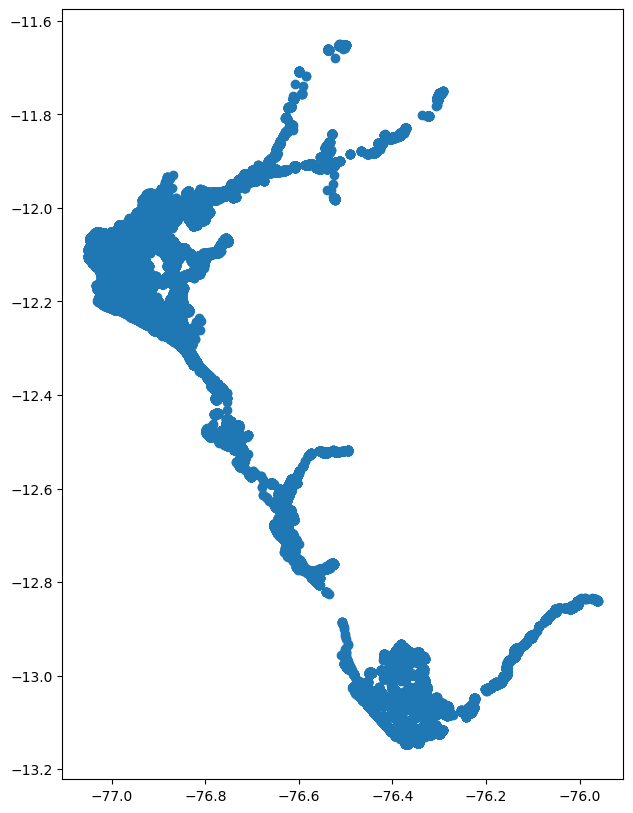

In [37]:
import matplotlib.pyplot as plt

# Plotando os pontos, apenas para ver se está tudo certo

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(geodf.geometry.x, geodf.geometry.y)
ax.set_aspect('equal')
plt.show()

In [38]:
# Mostrando os 10 distritos com mais pontos, apenas para saber qual distrito plotar
geodf['DISTRITO'].value_counts().head(10)

DISTRITO
SANTIAGO DE SURCO          129513
ATE-VITARTE                124173
VILLA MARIA DEL TRIUNFO     82921
SAN JUAN DE MIRAFLORES      75311
VILLA EL SALVADOR           73557
MIRAFLORES                  71667
CHORRILLOS                  69564
LA VICTORIA                 56044
LA MOLINA                   49887
SAN BORJA                   46394
Name: count, dtype: int64

In [39]:

# Criando um novo geodataframe apenas com as colunas geometry e DISTRITO
geodf_minimizado = geodf[['geometry', 'DISTRITO']]

# Filtrando apenas os pontos do distrito de La Victoria
geodf_minimizado = geodf_minimizado[geodf_minimizado["DISTRITO"] == "LA VICTORIA"]

# Subtraindo 0.0022 do x e 0.0032 do y para que os pontos fiquem mais centralizados
# Obs: Isso é necessário pois o plotly não está plotando os pontos no local correto
# Obs2: Não sei porque isso está acontecendo, mas acredito que seja alguma conversão de sistema de coordenadas
# Obs3: Esses valores foram encontrados na tentativa e erro, não sei se são os valores corretos
geodf_minimizado['geometry'] = geodf_minimizado['geometry'].apply(lambda x: Point(x.x - 0.0022, x.y - 0.0032))

# Juntando os pontos que estão na mesma localização e criando uma nova coluna
# com a quantidade de pontos naquela localização, chamada count
geodf_plot = geodf_minimizado.groupby('geometry').size().reset_index(name='count')

# Resentando o index para que o geopandas consiga plotar
geodf_plot.reset_index(drop=True, inplace=True)


geodf_plot.head()

geometry  count
0  POINT (-77.03599 -12.11179)      1
1  POINT (-77.02020 -12.09001)      1
2  POINT (-77.02025 -12.09001)      1
3  POINT (-77.02055 -12.08918)      1
4  POINT (-77.02055 -12.08891)      1

In [40]:
# Plotando o geodf_plot, onde cada ponto representa a quantidade de pontos naquela localização

px.set_mapbox_access_token(open("mapbox_token").read())
fig = px.scatter_mapbox(
    geodf_plot,
    lat=geodf_plot.geometry.apply(lambda p: p.y),
    lon=geodf_plot.geometry.apply(lambda p: p.x),
    color=geodf_plot['count'],
    size=geodf_plot['count'],
    color_continuous_scale=px.colors.sequential.Rainbow,
    size_max=15,
    zoom=12.3
)

# Mudando o centro do mapa para o centro do departamento de La Victoria
LAVICTORIA_departament_center = {"lat": -12.06748, "lon": -77.01595}

fig.update_layout(mapbox=dict(center=LAVICTORIA_departament_center))


fig.show()


In [41]:
import shapely.geometry as sg
import numpy as np




# Criando um multipoint a partir do geodataframe
multipoint = sg.MultiPoint(geodf_plot.geometry)


In [42]:
# Criando os quadrados que serão utilizados para escolher os pontos
# Primeiro, um retângulo maior é criado a partir dos pontos mais extremos
# Depois, calcula-se o centro desse retângulo e a distância do centro até os limites verticais e horizontais
# A partir disso, é criado um quadrado que tem como lado a maior distância encontrada, seja ela horizontal ou vertical
# Isso garante que todos os pontos estarão dentro do quadrado
# Por fim, dezenha-se os quadrados menores dentro do quadrado maior

# Criando o retângulo maior
bounding_box = multipoint.envelope

# Encontrando o centro do retângulo
centroid = bounding_box.centroid

bounding_box.bounds


# Calculando a distância do centro até os limites verticais e horizontais
distance = max(np.abs(centroid.x - bounding_box.bounds[0]),
               np.abs(centroid.y - bounding_box.bounds[1]))

# Criando o quadrado maior, a partir do centro e da distância
enveloping_square = sg.box(centroid.x - distance, centroid.y - distance,
                           centroid.x + distance, centroid.y + distance)

# Escolhendo o número de quadrados menores que estarão em um lado do quadrado maior
# No total, serão criados num_squares^2 quadrados menores
num_squares = 20

# Calculando a largura de cada quadrado menor, lembrando que o quadrado maior tem lado igual a 2 * distance
square_width = distance * 2 / num_squares

# Cria uma lista com as coordenadas dos quadrados menores
square_coordinates = []

# Criando uma lista com os quadrados menores
squares = []

# Iterando e criando os quadrados menores
for i in range(num_squares):
    for j in range(num_squares):
        square = sg.box(
            enveloping_square.bounds[0] + i * square_width,
            enveloping_square.bounds[1] + j * square_width,
            enveloping_square.bounds[0] + (i + 1) * square_width,
            enveloping_square.bounds[1] + (j + 1) * square_width
        )
        squares.append(square)
        square_coordinates.append(list(square.exterior.coords))

# Extraindo as coordenadas x e y dos quadrados menores, necessárias para o plotly desenhar as linhas
x_coords = []
y_coords = []

for coordinates in square_coordinates:
    x, y = zip(*coordinates)
    x_coords.append(x)
    y_coords.append(y)


# Add scatter_mapbox trace for the sub-squares
for i in range(len(square_coordinates)):
    fig.add_trace(go.Scattermapbox(
        lat=y_coords[i],
        lon=x_coords[i],
        mode='lines',
        line=dict(
            color='red',
            width=2
        ),
        name=f'Square {i}'
    ))

# Excluindo a legenda, pois tinha muitos quadrados
fig.update_layout(showlegend=False)


# Centralizando o mapa no centro do retângulo maior

fig.update_layout(mapbox=dict(center=dict(lat=centroid.y, lon=centroid.x)))


fig.show()


In [43]:
# Creating a function that receives the coordinates of a square and a list
# of points and returns the number of points inside the square

def count_points_in_square(square, points):
    """Counts the number of points inside a square, excluding points that share the same coordinates.

    Parameters
    ----------
    square : shapely.geometry.Polygon
        A square defined by a shapely Polygon object.
    points : list
        A list of shapely Point objects.

    Returns
    -------
    int
        The number of points inside the square.
    """
    return sum([point.within(square) for point in points])

def points_in_square(square, points):
    """ returns the points inside a square
    
    Parameters
    ----------
    square : shapely.geometry.Polygon
        A square defined by a shapely Polygon object.
    points : list
        A list of shapely Point objects.

    Returns
    -------
    list
        The points inside the square.
    """
    
    return [point for point in points if point.within(square)]


    


In [45]:
print(f'Número de pontos dentro do quadrado 296: {count_points_in_square(squares[296], geodf_minimizado.geometry)}')
print(f'Número de pontos dentro do quadrado 316: {count_points_in_square(squares[316], geodf_minimizado.geometry)}')

Número de pontos dentro do quadrado 149: 24
Número de pontos dentro do quadrado 296: 651
Número de pontos dentro do quadrado 316: 464
